# Feature Engineering

In [67]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

In [68]:
# Adjust settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
%matplotlib inline

In [69]:
# Load preprocessed dataset
data_path = '../data/interim/'
df = pd.read_pickle(os.path.join(data_path, 'explored.pkl'))

## Routing

In [70]:
# Create new feature for routing as dep arpt_arr arpt
df['routing'] = df['flt_dep_airpt'].astype(str) + '_' + df['flt_arr_airpt'].astype(str)
# Drop departure and arrival airport as all information is encoded in routing variable. Furthermore drop leg, as it is only a unique
# identifier similiar to the index.
df.drop(columns=['flt_dep_airpt', 'flt_arr_airpt', 'flt_leg'], inplace=True)

## Crew and Crew Changes

The TLC_trans variable seems to include several information. Firstly, there are the names of the crew including an indicator whether the crew member belongs to the flight (cp) or cabin (ca) crew. Secondly the second and thrid numbers after the name have a high correlation to the scheduled and actual transition times (nan where the values are 0). Therefore, this information will be extracted and stored in seperate columns.

In [71]:
# Save flight crew, cabin crew names, their size and transition times in new features and drop the original variable afterwards
cp_crew = []
ca_crew = []
cp_count = []
ca_count = []
act_trans_time = []
sched_trans_time = []

for crew in df['flt_TLC_trans']:
    cp_help = []
    ca_help = []
    att_help = []
    stt_help = []
    for member in crew:
        help = member.split('_')
        if 'cp' in help:
            cp_help.append(help[0])
        elif 'ca' in member:
            ca_help.append(help[0])
        if help[2] == 'nan':
            att_help.append(None)
        else:
            att_help.append(int(help[2]))
        if help[3] == 'nan':
            stt_help.append(None)
        else:
            stt_help.append(int(help[3]))
    cp_crew.append(sorted(cp_help))
    ca_crew.append(sorted(ca_help))
    cp_count.append(len(cp_help))
    ca_count.append(len(ca_help))
    act_trans_time.append(min((i for i in att_help if i != None), default=0))
    sched_trans_time.append(min((i for i in stt_help if i != None), default=0))

df['cp_crew'] = cp_crew
df['ca_crew'] = ca_crew
df['cp_count'] = cp_count
df['ca_count'] = ca_count
df['act_trans_time'] = act_trans_time
df['sched_trans_time'] = sched_trans_time

df = df.drop(columns='flt_TLC_trans')

In [72]:
# Create two new features from flt_crew_change:
# 1. Indicator whether cabin, flight or both crews changed aircraft
# 2. Number of crew members who changed aircraft
def crew_change_cp_ca (row):
    if all(x in row['flt_crewt_change'] for x in ['ca', 'cp']):
        return 'both'
    if 'cp' in row['flt_crewt_change']:
        return 'flight_crew'
    elif 'ca' in row['flt_crewt_change']:
        return 'cabin_crew'
    else:
        return 'None'

def crew_members (row):
    return len(row['flt_crewt_change'])

df['cc_cp_ca'] = df.apply(crew_change_cp_ca, axis=1)
df['cc_count'] = df.apply(crew_members, axis=1)

## Crosscheck of extracted and initial transition times

In [73]:
# Check mismatches in original transition time ans extracted information
act_tt_mismatch = df[(df['flt_tt'].astype(int) != df['act_trans_time'].astype(int))]
act_tt_mismatch

,flt_offblock,flt_onblock,flt_ac_reg,dep_delay,flt_tt,flt_sched_tt,flt_crewg,flt_crewt_change,flt_sched_dep,flt_sched_arr,gnd_mingt,arr_delay,AC_type,routing,sched_gt,act_gt,sched_gt_before,act_gt_before,cp_crew,ca_crew,cp_count,ca_count,act_trans_time,sched_trans_time,cc_cp_ca,cc_count


For the actuals everything seems to be fine as there are no missmatches between the two columns.

In [74]:
# Check mismatches in original transition time ans extracted information
sched_tt_mismatch = df[(df['flt_sched_tt'].astype(int) != df['sched_trans_time'].astype(int))]
print(sched_tt_mismatch.shape)
sched_tt_mismatch.head()


(53, 26)


,flt_offblock,flt_onblock,flt_ac_reg,dep_delay,flt_tt,flt_sched_tt,flt_crewg,flt_crewt_change,flt_sched_dep,flt_sched_arr,gnd_mingt,arr_delay,AC_type,routing,sched_gt,act_gt,sched_gt_before,act_gt_before,cp_crew,ca_crew,cp_count,ca_count,act_trans_time,sched_trans_time,cc_cp_ca,cc_count
4103,2019-06-11 12:22:00,2019-06-11 13:37:00,ECLBBX,72.0,24.0,60.0,C,"[cp, ca, ca, ca, cp]",2019-06-11 11:10:00,2019-06-11 12:25:00,45.0,72.0,321,East Carmen_Marioborough,45.0,90.0,115.0,190.0,"[Brandy Larsen, Frank Chaney]","[Angel Clark, Daniel King, Gregory Frost, Susa...",2,4,24,50,both,5
8949,2019-06-23 17:04:00,2019-06-23 18:25:00,ECLBBX,94.0,18.0,85.0,C,"[ca, ca, cp, ca]",2019-06-23 15:30:00,2019-06-23 17:05:00,45.0,80.0,321,East Carmen_Susanmouth,45.0,49.0,75.0,68.0,"[Christopher Foster, Eric Costa]","[Angela Byrd, Karen Kelly, Rachel Brown, Timot...",2,4,18,60,both,4
11838,2019-06-30 18:35:00,2019-06-30 20:58:00,ECLBCX,25.0,26.0,50.0,C,"[ca, ca, ca, cp, ca]",2019-06-30 18:10:00,2019-06-30 20:30:00,45.0,28.0,321,East Carmen_Desireeton,NaN,NaN,50.0,78.0,"[Carrie Hubbard, Marcus Little]","[Amy Howard, Katherine Hawkins, Philip Washing...",2,4,26,40,both,5
8863,2019-06-23 11:40:00,2019-06-23 12:59:00,ECLBDX,30.0,43.0,85.0,C,[cp],2019-06-23 11:10:00,2019-06-23 12:25:00,45.0,34.0,322,East Carmen_Marioborough,45.0,70.0,75.0,86.0,"[Alexandria Wright, Christopher Foster]","[Dana Fowler, Derek Graves, Emily Price, Lisa ...",2,4,43,65,flight_crew,1
8095,2019-06-21 11:26:00,2019-06-21 12:45:00,ECLBEX,36.0,52.0,55.0,C,"[ca, ca, ca, ca]",2019-06-21 10:50:00,2019-06-21 12:10:00,45.0,35.0,322,East Carmen_Lloydtown,45.0,60.0,50.0,89.0,"[Austin Ritter, Thomas Ross]","[Bruce Manning, Cynthia Fernandez, James Mille...",2,4,52,50,cabin_crew,4


As there are mismatches between the original and the extracted values, we will have a deeper look at a sample of flights where this occurs.

In [75]:
# Identifying specific aircraft wherer flt_sched_tt does not match sched_trans_time
sample = sched_tt_mismatch.sample(n=3, random_state=42)

sample.iloc[:,[2, 5, 8, 9, 13, 18, 19, 23]]

,flt_ac_reg,flt_sched_tt,flt_sched_dep,flt_sched_arr,routing,cp_crew,ca_crew,sched_trans_time
11114,ECLGAX,75.0,2019-06-28 20:45:00,2019-06-28 21:25:00,East Carmen_Port Courtneytown,"[Destiny Sanchez, Megan Dixon]","[Kelly Mcclure, Ms. Patricia Gardner]",35
6098,ECLGPX,65.0,2019-06-16 11:10:00,2019-06-16 12:10:00,East Carmen_North Christopherburgh,"[Daniel Fox, Zachary Ferguson]","[Aaron Stokes, Debra Johnson DVM]",55
11388,ECLGRX,50.0,2019-06-29 15:10:00,2019-06-29 16:00:00,East Carmen_Lake Richardberg,"[John Hardin, Mark Young]","[Brian Gonzalez, Tina Fisher]",45


In [76]:
# Now looking at the schedule of the crew members for that day (identification of crew member for which the sched_trans_time equals 35 min
# was done on a spreadsheet.
df[df.cp_crew.apply(lambda row: 'Destiny Sanchez' in row) & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-28')].sort_values(by=['flt_sched_dep']).iloc[:,[2, 5, 8, 9, 13, 18, 19, 23]]

,flt_ac_reg,flt_sched_tt,flt_sched_dep,flt_sched_arr,routing,cp_crew,ca_crew,sched_trans_time
11027,ECLGBX,0.0,2019-06-28 16:35:00,2019-06-28 17:20:00,Port Courtneytown_East Carmen,"[Destiny Sanchez, Melissa Williams]","[Cynthia Johnson, William Martinez]",0
11057,ECLGBX,40.0,2019-06-28 18:00:00,2019-06-28 18:50:00,East Carmen_North Anna,"[Destiny Sanchez, Melissa Williams]","[Cynthia Johnson, William Martinez]",40
11102,ECLGBX,30.0,2019-06-28 19:20:00,2019-06-28 20:10:00,North Anna_East Carmen,"[Destiny Sanchez, Melissa Williams]","[Cynthia Johnson, William Martinez]",30
11114,ECLGAX,75.0,2019-06-28 20:45:00,2019-06-28 21:25:00,East Carmen_Port Courtneytown,"[Destiny Sanchez, Megan Dixon]","[Kelly Mcclure, Ms. Patricia Gardner]",35


In [77]:
# Now looking at the schedule of the crew members for that day (identification of crew member for which the sched_trans_time equals 55 min
# was done on a spreadsheet.
df[df.cp_crew.apply(lambda row: 'Daniel Fox' in row) & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-16')].sort_values(by=['flt_sched_dep']).iloc[:,[2, 5, 8, 9, 13, 18, 19, 23]]

,flt_ac_reg,flt_sched_tt,flt_sched_dep,flt_sched_arr,routing,cp_crew,ca_crew,sched_trans_time
6051,ECLGBX,0.0,2019-06-16 09:25:00,2019-06-16 10:15:00,Lake Kevin_East Carmen,"[Daniel Fox, Lorraine Lewis]","[Mckenzie Diaz, Thomas Lowery MD]",0
6098,ECLGPX,65.0,2019-06-16 11:10:00,2019-06-16 12:10:00,East Carmen_North Christopherburgh,"[Daniel Fox, Zachary Ferguson]","[Aaron Stokes, Debra Johnson DVM]",55


In [78]:
# Now looking at the schedule of the crew members for that day (identification of crew member for which the sched_trans_time equals 45 min
# was done on a spreadsheet.
df[df.ca_crew.apply(lambda row: 'Tina Fisher' in row) & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-29')].sort_values(by=['flt_sched_dep']).iloc[:,[2, 5, 8, 9, 13, 18, 19, 23]]

,flt_ac_reg,flt_sched_tt,flt_sched_dep,flt_sched_arr,routing,cp_crew,ca_crew,sched_trans_time
11212,ECLGRX,0.0,2019-06-29 07:45:00,2019-06-29 08:40:00,East Carmen_Fisherhaven,"[Jeff Hays, Molly Woods]","[Catherine Rojas, Tina Fisher]",0
11264,ECLGRX,30.0,2019-06-29 09:10:00,2019-06-29 10:15:00,Fisherhaven_East Carmen,"[Jeff Hays, Kimberly Blair]","[Catherine Rojas, Tina Fisher]",30
11303,ECLGRX,40.0,2019-06-29 10:55:00,2019-06-29 12:20:00,East Carmen_Maryland,"[Preston Moreno, Sabrina Romero]","[Catherine Rojas, Tina Fisher]",40
11335,ECLGRX,35.0,2019-06-29 12:55:00,2019-06-29 14:25:00,Maryland_East Carmen,"[Preston Moreno, Sabrina Romero]","[Catherine Rojas, Tina Fisher]",35
11388,ECLGRX,50.0,2019-06-29 15:10:00,2019-06-29 16:00:00,East Carmen_Lake Richardberg,"[John Hardin, Mark Young]","[Brian Gonzalez, Tina Fisher]",45


For all samples which were used the extracted sched_trans_time is backed by the actual schedule of the crews on that day. Therefore, the extracted values will be carried on for actual and scheduled transition time and the original columns will be dropped.

In [79]:
# Dropping the initial columns for flt_tt and flt_sched_tt
df.drop(columns=['flt_tt', 'flt_sched_tt'], inplace=True)

## Day of the week and hour of the day features

In [80]:
# Create new features for day of the week and hour of the day
df['day_of_week'] = df['flt_sched_dep'].dt.dayofweek
df['hour_of_day_dep'] = df['flt_sched_dep'].dt.hour
df['hour_of_day_arr'] = df['flt_sched_arr'].dt.hour

## Flight of the day feature

In [81]:
# Create a counter for a specific aircraft that indicates which nth flight of the day the considered leg is.
df['dep_date'] = df['flt_sched_dep'].dt.date
df['flight_of_day'] = df.groupby(['dep_date', 'flt_ac_reg']).cumcount()+1
df.drop(columns='dep_date', inplace=True)

## Data Checks: Crew Changing variables

In [82]:
# Check whether flt_crewt_change and flt_crewg match
pd.crosstab(df['flt_crewg'], df['cc_count'])

cc_count,0,1,2,3,4,5,6,7,8
flt_crewg,,,,,,,,,
A,5108,166,123,172,184,187,3,1,1
B,493,0,0,0,0,0,0,0,0
B2,0,0,0,55,60,295,15,0,0
C,0,321,184,100,97,43,1,0,0
Start,4283,0,0,0,0,0,0,0,0


There seems to be a mismatch between the variables flt_crewg and the number of crew members who changed the aircraft based on the definition of the variable flt_crewg according to the documentation:
Crew Group: assignment of what happens to the whole crew after a flight
-  Start : First flight of day
-  A : all crew members stay on the aircraft for the next flight
-  B, B2: all crew members switch aircraft for the next flight
-  C: at least one crew member switches aircraft for the next flight

For flt_crewg == A there should only be cc_count == 0 and for flt_crewg == B there should only be cc_count != 0. Therefore a further analysis is done on that.

In [83]:
# Identifying a specific aircraft wherer flt_crewg == A and cc_count != 0 to analyse the crew changes for a specific date
condition = ((df['flt_crewg'] == 'A') & (df['cc_count'] != 0))
sample = df[condition].sample(n=3, random_state=42)

sample

,flt_offblock,flt_onblock,flt_ac_reg,dep_delay,flt_crewg,flt_crewt_change,flt_sched_dep,flt_sched_arr,gnd_mingt,arr_delay,AC_type,routing,sched_gt,act_gt,sched_gt_before,act_gt_before,cp_crew,ca_crew,cp_count,ca_count,act_trans_time,sched_trans_time,cc_cp_ca,cc_count,day_of_week,hour_of_day_dep,hour_of_day_arr,flight_of_day
6614,2019-06-17 16:05:00,2019-06-17 17:40:00,ECLBUX,30.0,A,"[ca, cp, ca, cp, ca]",2019-06-17 15:35:00,2019-06-17 17:20:00,40.0,20.0,320,East Carmen_North Jeffrey,45.0,37.0,55.0,52.0,"[Danny Blackburn, Mckenzie Reed]","[Jose Trujillo, Kristie Lopez, Mike Collins, T...",2,4,49,55,both,5,0,15,17,6
3247,2019-06-09 08:26:00,2019-06-09 10:22:00,ECLXEX,16.0,A,"[cp, ca, cp, ca, ca]",2019-06-09 08:10:00,2019-06-09 09:45:00,40.0,37.0,320,East Carmen_Youngland,45.0,11.0,55.0,67.0,"[Joseph Myers, Theresa West]","[Deborah Watson, Joseph Davis, Joshua Matthews...",2,4,48,55,both,5,6,8,9,2
7644,2019-06-20 09:02:00,2019-06-20 11:35:00,ECLBKX,62.0,A,"[ca, cp, cp, ca]",2019-06-20 08:00:00,2019-06-20 10:45:00,40.0,50.0,320,East Carmen_Ryanland,50.0,5.0,65.0,105.0,"[Adam Bell, Michael James]","[Barbara Stout, James Cannon, Jessica Lutz, Ni...",2,4,66,65,both,4,3,8,10,2


In [84]:
# Now looking at the crew change history of the first registration for the specific day
df[(df['flt_ac_reg'] == 'ECLBUX') & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-17')].iloc[:,[0, 4, 5, 16, 17, 23]]

,flt_offblock,flt_crewg,flt_crewt_change,cp_crew,ca_crew,cc_count
6310,2019-06-17 02:41:00,Start,[],"[Holly Roberts, Keith Henson]","[Makayla Rivera, Nathan Jackson, Philip Washin...",0
6363,2019-06-17 05:43:00,Start,[],"[Angela Watson, Lydia Carpenter]","[Benjamin Davis, Megan Taylor, Michael Long, W...",0
6452,2019-06-17 09:06:00,A,[],"[Angela Watson, Lydia Carpenter]","[Benjamin Davis, Megan Taylor, Michael Long, W...",0
6493,2019-06-17 11:10:00,A,"[ca, cp, ca, ca]","[Lydia Carpenter, Ryan Thompson]","[Megan Taylor, Michael Long, Victoria Rhodes, ...",4
6553,2019-06-17 13:44:00,A,[ca],"[Danny Blackburn, Mckenzie Reed]","[Jose Trujillo, Kristie Lopez, Tracy Martin, V...",1
6614,2019-06-17 16:05:00,A,"[ca, cp, ca, cp, ca]","[Danny Blackburn, Mckenzie Reed]","[Jose Trujillo, Kristie Lopez, Mike Collins, T...",5
6670,2019-06-17 18:17:00,A,[],"[Danny Blackburn, Mckenzie Reed]","[Jose Trujillo, Kristie Lopez, Mike Collins, T...",0


Based on the hypothesis that the names of the crews are being recorded correctly as this might not only be relevant for payroll accounting, but also from regulative perspective the flt_crewg and flt_crewt_change values should be the following:
|   | flt_crewg | flt_crewt_change |
| --- | --- | --- |
6310 | Start | [] |
6363 | B | [cp, cp, ca, ca, ca, ca] |
6452 | A | [] |
6493 | C | [cp, ca, ca, ca] |
6553 | B | [cp, cp, ca, ca, ca, ca] |
6614 | A | [] |
6670 | A | [] |

In [85]:
# Let's have a detailed look at the second example
df[(df['flt_ac_reg'] == 'ECLXEX') & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-09')].iloc[:,[0, 4, 5, 16, 17, 23]]

,flt_offblock,flt_crewg,flt_crewt_change,cp_crew,ca_crew,cc_count
3196,2019-06-09 05:50:00,Start,[],"[Joseph Myers, Theresa West]","[Deborah Watson, Emily Velazquez, Joseph Davis...",0
3247,2019-06-09 08:26:00,A,"[cp, ca, cp, ca, ca]","[Joseph Myers, Theresa West]","[Deborah Watson, Joseph Davis, Joshua Matthews...",5
3284,2019-06-09 10:33:00,A,[],"[Joseph Myers, Theresa West]","[Deborah Watson, Joseph Davis, Joshua Matthews...",0
3371,2019-06-09 13:52:00,Start,[],"[Jennifer Pitts MD, Monique Hall]","[Barbara Matthews, Elizabeth Marks, Holly Stan...",0
3412,2019-06-09 15:55:00,A,[],"[Jennifer Pitts MD, Monique Hall]","[Barbara Matthews, Elizabeth Marks, Holly Stan...",0
3471,2019-06-09 18:52:00,C,[cp],"[Alexis Finley, Johnny Johnson]","[Logan Rodriguez, Rebecca Shaffer, Ryan Arroyo...",1


For the second example the values should be the following:
|   | flt_crewg | flt_crewt_change |
| --- | --- | --- |
3196 | Start | [] |
3247 | C | [ca, ca] |
3284 | A | [] |
3371 | B | [cp, cp, ca, ca, ca, ca] |
3412 | A | [] |
3471 | B | [cp, cp, ca, ca, ca, ca] |

In [86]:
# Let's have a detailed look at the third example
df[(df['flt_ac_reg'] == 'ECLBKX') & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-20')].iloc[:,[0, 4, 5, 16, 17, 23]]

,flt_offblock,flt_crewg,flt_crewt_change,cp_crew,ca_crew,cc_count
7602,2019-06-20 05:50:00,Start,[],"[Adam Bell, Michael James]","[Barbara Stout, James Cannon, Kathryn King, Su...",0
7644,2019-06-20 09:02:00,A,"[ca, cp, cp, ca]","[Adam Bell, Michael James]","[Barbara Stout, James Cannon, Jessica Lutz, Ni...",4
7740,2019-06-20 11:40:00,A,[],"[Adam Bell, Michael James]","[Barbara Stout, James Cannon, Jessica Lutz, Ni...",0
7804,2019-06-20 16:24:00,Start,[],"[Kimberly Campbell, Mark Vega]","[Charles Martin, Jose Trujillo, Kelly Warner, ...",0
7888,2019-06-20 18:33:00,A,[],"[Kimberly Campbell, Mark Vega]","[Charles Martin, Jose Trujillo, Kelly Warner, ...",0


For the second example the values should be the following:
|   | flt_crewg | flt_crewt_change |
| --- | --- | --- |
7602 | Start | [] |
7644 | C | [ca, ca] |
7740 | A | [] |
7804 | B | [cp, cp, ca, ca, ca, ca] |
7888 | A | [] |

Within this sample, only a few entries in flt_crewg and flt_crewt_change match with the crew data over the rotation of a single registration for a day. Furthermore, there is a general error in the variable flt_crewg as it always shows Start for the first leg of the day, however the variable shall state "what happens to the whole crew after a flight". As for the prediction of the arrival delay it is more interesting which crew changes happened prior the flight, the definition of the varibale will be changes to "what happened to the crew after the previous fligth" and therefore Start for the first leg of the day is correct.
Due to this, new features to capture crew changes will be established based on the columns cp_crew and ca_crew for the rotation of a specific aircraft on any given day.

In [87]:
# Creating new features to track crew changes from the flight before: cc_type {0: Start - First flight of the day, 1: No crew change;
# 2: At least one member, but not all of the crew changed; 3: Whole crew changed}; cc_roles [list of elements either ca or cp with an
# entry for every crew member that changed aircraft]

def crew_changes (registrations):
    # Create an empty df that will be appended in every step and finally returned by the function
    cc = pd.DataFrame(columns=['cc_types', 'cc_roles'])
    # Loop through the aircrafts and sort their flights by sched_dep
    for aircraft in registrations:
        indexes = df[df['flt_ac_reg'] == aircraft].sort_values(by='flt_sched_dep').index
        date = '2019-01-01'
        # Loop through the indexes of a specific aircraft
        for idx in indexes:
            cc_roles = []
            # If index has new date and therefore is first flight of the day
            if date not in str(df['flt_sched_dep'].loc[idx]):
                date = str(df['flt_sched_dep'].loc[idx]).partition(' ')[0]
                cp = df['cp_crew'].loc[idx]
                ca = df['ca_crew'].loc[idx]
                help = pd.DataFrame([[0, []]], columns=['cc_types', 'cc_roles'], index=[idx])
            else:
                # Check differences between flight and cabin crew from previous flight
                dif_cp = list(set(cp) - set(df['cp_crew'].loc[idx]))
                dif_ca = list(set(ca) - set(df['ca_crew'].loc[idx]))
                # If no crew members changed
                if (len(dif_cp) == 0) and (len(dif_ca) == 0):
                    help = pd.DataFrame([[1, []]], columns=['cc_types', 'cc_roles'], index=[idx])
                # If all crew members changed
                elif (len(dif_cp) >= len(cp)) and (len(dif_ca) >= len(ca)):
                    for item in dif_cp:
                        cc_roles.append('cp')
                    for item in dif_ca:
                        cc_roles.append('ca')
                    help = pd.DataFrame([[3, cc_roles]], columns=['cc_types', 'cc_roles'], index=[idx])
                else:
                    for item in dif_cp:
                        cc_roles.append('cp')
                    for item in dif_ca:
                        cc_roles.append('ca')
                    help = pd.DataFrame([[2, cc_roles]], columns=['cc_types', 'cc_roles'], index=[idx])
                cp = df['cp_crew'].loc[idx]
                ca = df['ca_crew'].loc[idx]
            cc = cc.append(help)
    return cc

# Create a list of all registrations in the dataset
registrations = df['flt_ac_reg'].unique()

df = pd.merge(df, crew_changes(registrations), left_index=True, right_index=True)
# Finally drop old columns
df.drop(columns=['flt_crewg', 'flt_crewt_change'], inplace=True)

In [88]:
# Create two new features from flt_crew_change:
# 1. Indicator whether cabin, flight or both crews changed aircraft
# 2. Number of crew members who changed aircraft
def crew_change_cp_ca (row):
    if all(x in row['cc_roles'] for x in ['ca', 'cp']):
        return 'both'
    if 'cp' in row['cc_roles']:
        return 'flight_crew'
    elif 'ca' in row['cc_roles']:
        return 'cabin_crew'
    else:
        return 'none'

def crew_members (row):
    return len(row['cc_roles'])

df['cc_cp_ca'] = df.apply(crew_change_cp_ca, axis=1)
df['cc_count'] = df.apply(crew_members, axis=1)
df.drop(columns=['cp_crew', 'ca_crew'], inplace=True)

## Density feature for arrivals at hubEast Carmen
Check if there is an impact of many flights arriving at the same time of the day at the hub East Carmen which might lead to queing of aircraft before being able to land.

In [89]:
# Firstly, create a feature to indicate at which time of a day the aircraft has its scheduled arrival
df['mod_sched_arr'] = df['flt_sched_arr'].dt.hour * 60 + df['flt_sched_arr'].dt.minute
# Secondly, extract the arrival airport out of the routing to identify flights arriving at East Carmen
df['arr_airpt'] = df['routing'].str.partition('_')[2]

<AxesSubplot:xlabel='mod_sched_arr', ylabel='Density'>

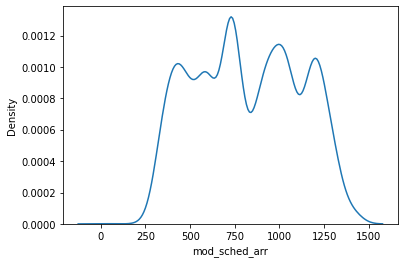

In [90]:
temp = df[df['arr_airpt'] != 'East Carmen']
sns.kdeplot(data=temp['mod_sched_arr'])

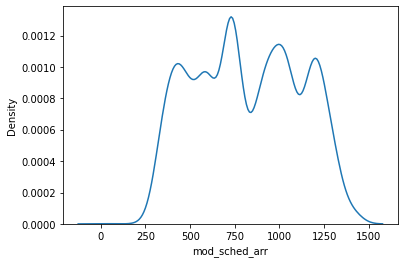

In [91]:
# Getting data from a kde plot showing the arrivals over time to add it as a feature
arr_density = pd.DataFrame(sns.kdeplot(data=temp['mod_sched_arr']).lines[0].get_data()).T
arr_density.columns=['minute', 'density']

In [92]:
df_merged = df.merge(arr_density, how='cross')
df_merged['min_diff'] = abs(df_merged['mod_sched_arr']-df_merged['minute'])
df_merged = df_merged.sort_values(by='min_diff').drop_duplicates(subset=['flt_offblock', 'flt_onblock', 'routing']).drop(columns=['minute', 'min_diff'])
df_merged['density'] = np.where(df_merged['arr_airpt'] == 'East Carmen', df_merged['density']*100, 0)
df = df_merged.drop(columns='arr_airpt')

## Adjusting Data Types prior to further analysis

In [93]:
# Checking current data types
df.dtypes

flt_offblock        datetime64[ns]
flt_onblock         datetime64[ns]
flt_ac_reg                  object
dep_delay                  float64
flt_sched_dep       datetime64[ns]
flt_sched_arr       datetime64[ns]
gnd_mingt                  float64
arr_delay                  float64
AC_type                   category
routing                     object
sched_gt                   float64
act_gt                     float64
sched_gt_before            float64
act_gt_before              float64
cp_count                     int64
ca_count                     int64
act_trans_time               int64
sched_trans_time             int64
cc_cp_ca                    object
cc_count                     int64
day_of_week                  int64
hour_of_day_dep              int64
hour_of_day_arr              int64
flight_of_day                int64
cc_types                    object
cc_roles                    object
mod_sched_arr                int64
density                    float64
dtype: object

In [94]:
convert_dict = {'day_of_week': 'object',
                'hour_of_day_dep': 'object',
                'hour_of_day_arr': 'object',
                'flight_of_day': 'object'
}
df = df.astype(convert_dict)

In [95]:
df.shape

(11892, 28)

In [96]:
df.to_csv('../data/interim/features.csv')
df.to_pickle('../data/interim/features.pkl')